<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>


# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import pandas as pd
import numpy as np

import os
import skimage.io
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.manifold import TSNE

import plotly.express as px

from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

!nvidia-smi

CUDA is available!  Training on GPU ...
cuda
Tue Dec 20 00:05:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    29W /  70W |      3MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                           

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    #print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_label = df[["person"]]
    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    #print(all_photos)
    #print(all_attrs)
    return all_photos, all_attrs, all_label

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs, label = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
random_state = 151222

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, 
                                                                    shuffle=False, 
                                                                    random_state=random_state)
train_loader = torch.utils.data.DataLoader(torch.FloatTensor(train_photos).permute(0,3,1,2), batch_size=40)
val_loader = torch.utils.data.DataLoader(torch.FloatTensor(val_photos).permute(0,3,1,2), batch_size=40)

#train_loader = torch.utils.data.DataLoader(torch.FloatTensor(train_photos), batch_size=28)
#val_loader = torch.utils.data.DataLoader(torch.FloatTensor(val_photos), batch_size=28)

In [ ]:
train_photos.shape,  train_attrs.shape

((11828, 64, 64, 3), (11828, 73))

In [ ]:
for batch in train_loader:
  b = batch.shape
  print(b)
  x = batch.view(batch.size(0), batch.size(1), -1)
  print(x.shape)
  break

torch.Size([40, 3, 64, 64])
torch.Size([40, 3, 4096])


In [ ]:
label['person'].iloc[1]

'Aaron Guiel'

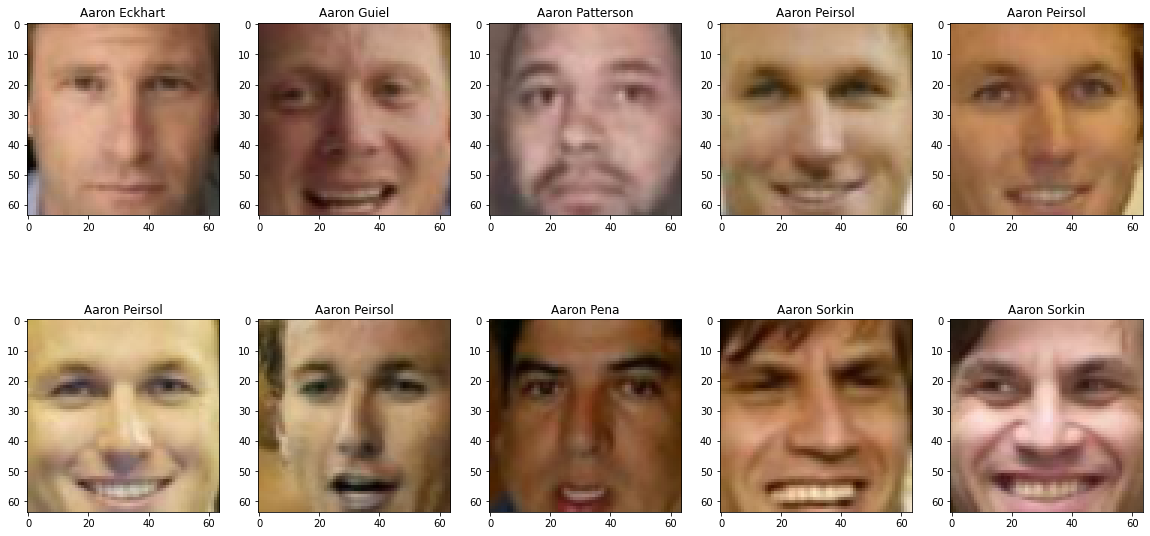

In [ ]:
fig = plt.figure(figsize=(20, 10))
pch = train_photos[:10]
for i, fig_x in enumerate(pch):  
    fig.add_subplot(2, 5, i+1) 
    plt.imshow(fig_x)
    plt.title(label['person'].iloc[i])
    
plt.show()        

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 16 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

Попробуем сначала поиграться просто с линейными слоями. Сверточные посмотрим дальше. 

In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.flatten = nn.Flatten()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(3*64*64, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, dim_code)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(dim_code, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 3*64*64),
            torch.nn.Sigmoid()
        )
    
    def forward(self, sample):
        shapes = sample.shape
        sample = self.flatten(sample).float()
        latent = self.encoder(sample)
        reconstructed = self.decoder(latent)
        return reconstructed.view(*shapes) , latent

    def sample(self, sample):
        reconstruction = self.decoder(sample)
        return reconstruction.view(-1, 3, 64, 64 ) 

In [ ]:
summary(Autoencoder().to(device), (3, 64, 64) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 12288]               0
            Linear-2                 [-1, 1024]      12,583,936
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 16]           2,064
           Linear-11                  [-1, 128]           2,176
             ReLU-12                  [-1, 128]               0
           Linear-13                  [-1, 256]          33,024
             ReLU-14                  [

In [ ]:
lr = 3e-4
criterion = nn.MSELoss()
model = Autoencoder().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
epochs = 150

In [ ]:
#from torch.nn.modules.container import ModuleList

def train_ae(model, optimizer, epochs=epochs, learning_rate=lr, train_history=None, valid_history=None):
           
  train_losses = []
  val_losses = []
  best_valid_loss = float('inf')

  criterion = nn.MSELoss()

  for epoch in tqdm(range(epochs)):
      model.train()
      train_losses_per_epoch = []

      for batch in train_loader:        
          optimizer.zero_grad()
          #print(batch.shape)
          reconstruction, latent = model(batch.to(device))
          #print(reconstruction.shape)
          #reconstruction = reconstruction.view(-1, 64, 64, 3)
          loss = criterion(reconstruction, batch.to(device))
          loss.backward()
          optimizer.step()
          train_losses_per_epoch.append(loss.item())

      train_losses.append(np.mean(train_losses_per_epoch))

      model.eval()
      val_losses_per_epoch = []
      with torch.no_grad():
          for batch in val_loader:
            cur_batch = batch.to(device)
            #print(cur_batch.shape)
            reconstruction, latent = model(cur_batch)
            #print(f'rec= {reconstruction.shape} lat {latent.shape}')
            #reconstruction = reconstruction.view(-1, 64, 64, 3)
            loss = criterion(reconstruction, cur_batch)
            val_losses_per_epoch.append(loss.item())

      val_losses.append(np.mean(val_losses_per_epoch))

      if val_losses[epoch] < best_valid_loss:
            best_valid_loss = val_losses[epoch]
                     
      fig, ax = plt.subplots(2, 6, figsize = (12, 8))
      for k in range(6):
          ax[0, k].imshow(cur_batch[k].detach().cpu().permute(1,2,0), cmap='gray') 
          ax[0, k].set_title("\nReal")
          ax[0, k].axis('off')
          ax[1, k].imshow(reconstruction[k].squeeze().cpu().permute(1,2,0), cmap='gray') 
          ax[1, k].set_title("Output")
          ax[1, k].axis('off')    

      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
      clear_output(True)
      if train_losses is not None:
          ax.plot(train_losses, label='general train history')
          ax.set_xlabel('Epoch')
          ax.set_title('Train and Val loss')
      if val_losses is not None:
          ax.plot(val_losses, label='general valid history')
          
      plt.legend()
      plt.show()  

      print(f'Epoch: {epoch+1:01}')
      print(f'Train Loss: {train_losses[epoch]:.3f}')
      print(f' Val. Loss: {val_losses[epoch]:.3f}')

  return train_losses, val_losses 


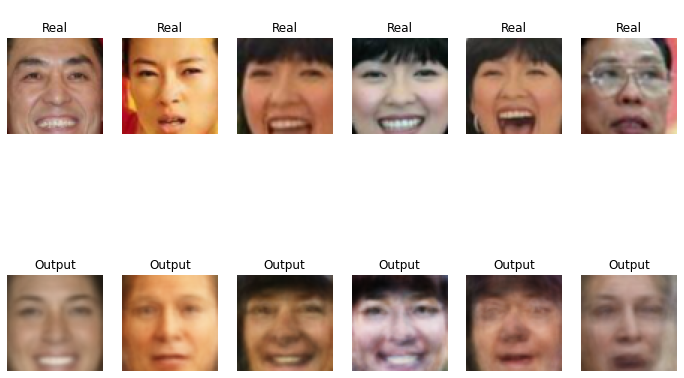

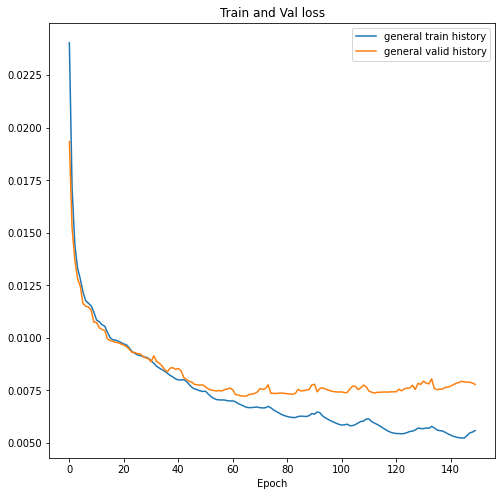

Epoch: 150
Train Loss: 0.006
 Val. Loss: 0.008


In [ ]:
train_losses_ae, val_losses_ae = train_ae(model, optimizer=optimizer)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
model.eval()
with torch.no_grad():
    for batch in val_loader:
      reconstruction, _ = model(batch.to(device))
      reconstruction = reconstruction.permute(0,2,3,1)
      result = reconstruction.cpu().detach().numpy()
      gt = batch.permute(0,2,3,1)
      ground_truth = gt.cpu().numpy()
      break

In [ ]:
ground_truth.shape, result.shape

((40, 64, 64, 3), (40, 64, 64, 3))

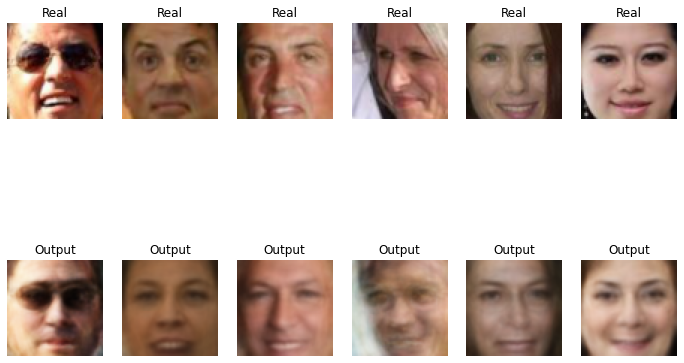

In [ ]:
fig, ax = plt.subplots(2, 6, figsize = (12, 8))
for k in range(6):
    ax[0, k].imshow(ground_truth[k], cmap='gray')
    ax[0, k].set_title("Real")
    ax[0, k].axis('off')
    ax[1, k].imshow(result[k], cmap='gray')
    ax[1, k].set_title("Output")
    ax[1, k].axis('off')  

In [ ]:
torch.save(model.state_dict(), 'best-val-AE-model.pt')

Not bad, right? 

Yes, really not so bad!

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

(25, 3, 64, 64)


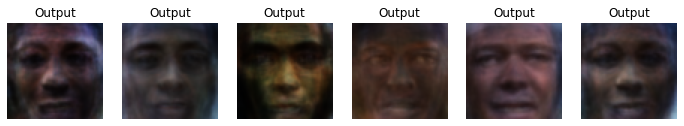

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
rand_latent = np.random.randn(25, dim_code)
output = model.sample(torch.FloatTensor(rand_latent).to(device))
out = output.cpu().detach().numpy()
print(out.shape)
out = output.permute(0,2,3,1).cpu().detach()


fig, ax = plt.subplots(1, 6, figsize = (12, 8))
for k in range(6):    
    ax[k].imshow(out[k], cmap='gray')
    ax[k].set_title("Output")
    ax[k].axis('off')  

plt.show()

In [ ]:
latents = torch.FloatTensor()
model.eval()
with torch.no_grad():
    for batch in train_loader:
      reconstruction, latent = model(batch.to(device))
    latents = torch.cat((latents, latent.cpu()), dim=0)

(25, 3, 64, 64)


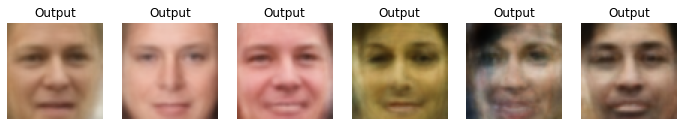

In [ ]:
# нормализуем сгенерированные случайные рандомные вектора 
# по среднему и стандартному отклонению по всем обучающим батчам
rand_latent_new = torch.randn(25, dim_code)*torch.std(latents, axis=0)+torch.mean(latents, axis=0) 
output = model.sample(torch.FloatTensor(rand_latent_new).to(device))
out = output.cpu().detach().numpy()
print(out.shape)
out = output.permute(0,2,3,1).cpu().detach()


fig, ax = plt.subplots(1, 6, figsize = (12, 8))
for k in range(6):    
    ax[k].imshow(out[k], cmap='gray')
    ax[k].set_title("Output")
    ax[k].axis('off')  

plt.show()

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# 16 самых грустных людей
sad_indx = attrs.sort_values('Smiling', ascending=True)['Smiling'].head(16).index
sad_indx

Int64Index([11571,  1234,  7506,  5458,  7065, 11912,  1654,   471,  8410,
             8596, 12688,  1432, 10097, 10506,  9114,  6321],
           dtype='int64')

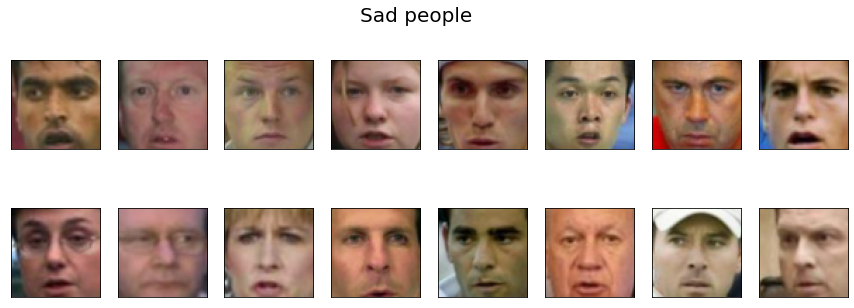

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(15, 5), sharey=True, sharex=True)
count = 0

for fig_x in ax.flatten():
    fig_x.imshow(data[sad_indx[count]])
    plt.xticks([])
    plt.yticks([])
    count += 1
plt.suptitle('Sad people', fontsize=20)
plt.show()

In [ ]:
# 16 самых веселых людей
smile_indx = attrs.sort_values('Smiling', ascending=False)['Smiling'].head(16).index
smile_indx

Int64Index([ 8643,  1816, 13034,  5624,  1045,  4681,  6139, 11797,  1359,
             2031,  1955,  9004,   459,  6166,   682,   983],
           dtype='int64')

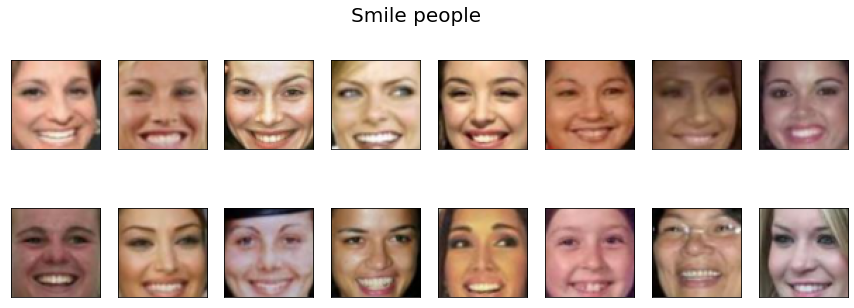

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(15, 5), sharey=True, sharex=True)
count = 0

for fig_x in ax.flatten():
    fig_x.imshow(data[smile_indx[count]])
    plt.xticks([])
    plt.yticks([])
    count += 1
plt.suptitle('Smile people', fontsize=20)
plt.show()

In [ ]:
latent_smile = torch.FloatTensor().to(device)
latent_sad = torch.FloatTensor().to(device)

In [ ]:
# латентный вектор для грустных людей
for indx in sad_indx:
  sad_image = torch.FloatTensor(data[indx]).permute(2, 0, 1).unsqueeze(0).to(device)
  with torch.no_grad():
    _, latent = model(sad_image)
  latent_sad = torch.cat((latent_sad, latent))

# латентный вектор для улыбающихся людей
for idx in smile_indx:
  smile_image = torch.FloatTensor(data[idx]).permute(2, 0, 1).unsqueeze(0).to(device)
  with torch.no_grad():
    _, latent = model(smile_image)
  latent_smile = torch.cat((latent_smile, latent))

In [ ]:
# вектор улыбки - разность между средним латентным вектором улыбающихся людей
# и средним латентным вектором грустных людей
latent_smile_mean = torch.mean(latent_smile, axis=0)
latent_sad_mean = torch.mean(latent_sad, axis=0)
smile = latent_smile_mean - latent_sad_mean


In [ ]:
# приделаем улыбку грустному человеку
latent_sad_plus_smile = latent_sad + smile

# прогоним полученный вектор через decoder
with torch.no_grad():
    output = model.sample(latent_sad_plus_smile)
    out = output.cpu().permute(0, 2, 3, 1)

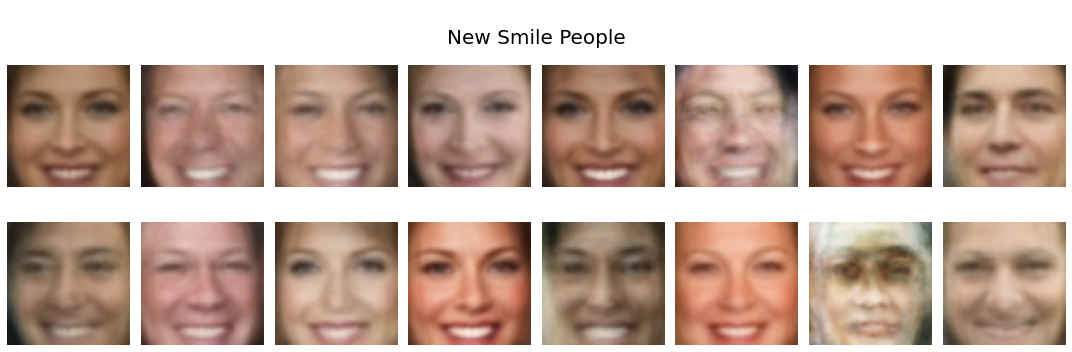

In [ ]:
fig, ax = plt.subplots(2, 8, figsize=(15, 5))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(out[i], cmap='gray')
    plt.axis('off')
plt.suptitle('\nNew Smile People', fontsize=20, y=1.05)    
plt.tight_layout()
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
for batch in train_loader:
  print(batch[0].shape, batch[1].shape)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
latent_dim = 8
features = 10

Попробуем реализовать VAE со свертками.

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.flatten = nn.Flatten()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 16, momentum = 0.05),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 32, momentum = 0.05),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 64, momentum = 0.05),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 128, momentum = 0.05),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 256, momentum = 0.05),
            nn.LeakyReLU())
        
        self.decoder_input = nn.Linear(latent_dim, 256)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = 128, momentum = 0.05),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = 64, momentum = 0.05),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(num_features = 32, momentum = 0.05),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = 16, momentum = 0.05),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())
        
        self.mu = nn.Linear(256, latent_dim)        
        self.log_var = nn.Linear(256, latent_dim)        
                

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        z = self.decoder_input(z)
        z = z.view(-1, 256, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var
      
    def sample(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 256, 1, 1)
        generated = self.decoder(z)
        return generated

    def get_latent_vector(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        return z    

In [ ]:
summary(VAE().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
         LeakyReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]           4,640
       BatchNorm2d-5             [-1, 32, 7, 7]              64
         LeakyReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
       BatchNorm2d-8             [-1, 64, 4, 4]             128
         LeakyReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 2, 2]          73,856
      BatchNorm2d-11            [-1, 128, 2, 2]             256
        LeakyReLU-12            [-1, 128, 2, 2]               0
           Conv2d-13            [-1, 256, 1, 1]         295,168
      BatchNorm2d-14            [-1, 25

И обучим модель:

In [ ]:
epochs = 60
lr = 3e-4
criterion = loss_vae
model = VAE().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr, eps=1e-6, weight_decay=1e-5, amsgrad=False)

In [ ]:
def train_vae(model, optimizer, epochs=epochs, learning_rate=lr, train_history=None, valid_history=None):
           
  train_losses = []
  val_losses = []
  best_valid_loss = float('inf')

  for epoch in tqdm(range(epochs)):
      model.train()
      train_losses_per_epoch = []

      for batch in train_loader:
        optimizer.zero_grad()
        #print(batch[0].shape)
        reconstruction, mu, logsigma = model(batch[0].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

      train_losses.append(np.mean(train_losses_per_epoch))

      model.eval()
      val_losses_per_epoch = []
      
      with torch.no_grad():
          for batch in test_loader:
            cur_batch = batch[0].to(device)
            #print(cur_batch.shape)
            reconstruction, mu, logsigma = model(cur_batch)
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = criterion(cur_batch.float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

      val_losses.append(np.mean(val_losses_per_epoch))

      if val_losses[epoch] < best_valid_loss:
            best_valid_loss = val_losses[epoch]
            
      fig, ax = plt.subplots(2, 6, figsize = (12, 8))
      for k in range(6):
          
          ax[0, k].imshow(cur_batch[k].detach().cpu().squeeze(0), cmap='gray')
          ax[0, k].set_title("\nReal")
          ax[0, k].axis('off')
          ax[1, k].imshow(reconstruction[k].cpu().squeeze(0), cmap='gray')
          ax[1, k].set_title("Output")
          ax[1, k].axis('off')    

      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
      clear_output(True)
      if train_losses is not None:
          ax.plot(train_losses, label='general train history')
          ax.set_xlabel('Epoch')
          ax.set_title('Train and Val loss')
      if val_losses is not None:
          ax.plot(val_losses, label='general valid history')
          
      plt.legend()
      plt.show()  

      print(f'Epoch: {epoch+1:01}')
      print(f'Train Loss: {train_losses[epoch]:.3f}')
      print(f' Val. Loss: {val_losses[epoch]:.3f}')

  return train_losses, val_losses 

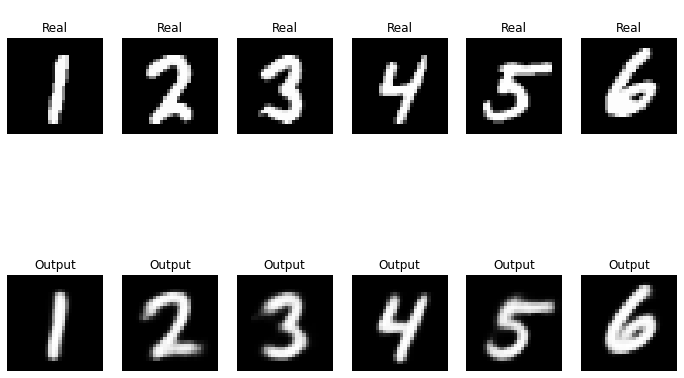

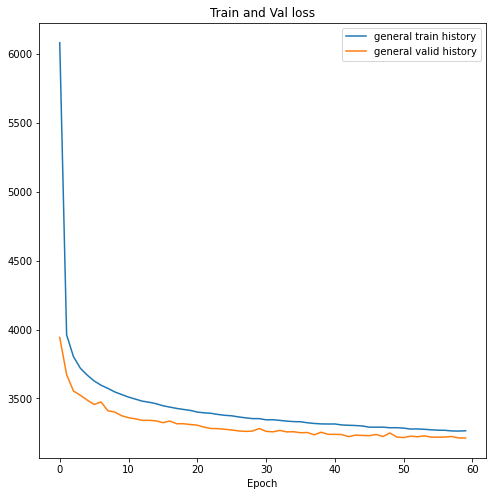

Epoch: 60
Train Loss: 3265.195
 Val. Loss: 3212.702


In [ ]:
train_losses_vae, val_losses_vae = train_vae(model, optimizer=optimizer)

In [ ]:
torch.save(model.state_dict(), 'best-val-VAE-model.pt')

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
      reconstruction, mu, logsigma = model(batch[0].to(device))
      reconstruction = reconstruction.view(-1, 1, 28, 28)
      result = reconstruction
      #result = reconstruction.cpu().numpy()
      ground_truth = batch[0].numpy()
      break

In [ ]:
ground_truth.shape, result[0].shape

((32, 1, 28, 28), torch.Size([1, 28, 28]))

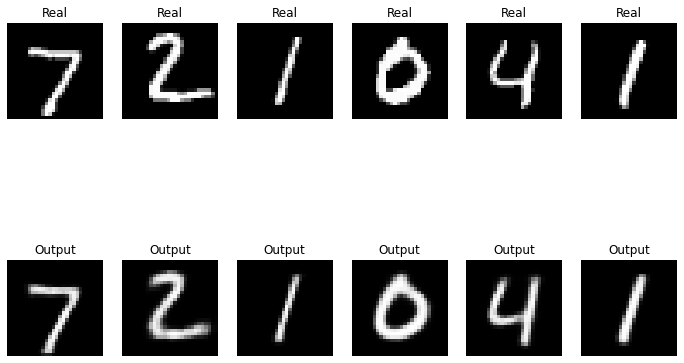

In [ ]:
fig, ax = plt.subplots(2, 6, figsize = (12, 8))
for k in range(6):
    ax[0, k].imshow(ground_truth[k].squeeze(), cmap='gray')
    ax[0, k].set_title("Real")
    ax[0, k].axis('off')
    ax[1, k].imshow(torch.squeeze(result[k]).cpu(), cmap='gray') #torch.squeeze(reconstructed.reshape(-1, 28, 28).cpu())
    ax[1, k].set_title("Output")
    ax[1, k].axis('off')  

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

## 2.2 Sampling

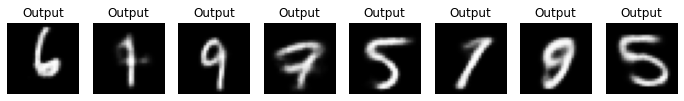

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.array([np.random.normal(0, 1, latent_dim) for i in range(10)])
output = model.sample(torch.FloatTensor(z).to(device))
out = torch.squeeze(output).cpu().detach().numpy()


fig, ax = plt.subplots(1, 8, figsize = (12, 8))
for k in range(8):    
    ax[k].imshow(out[k], cmap='gray')
    ax[k].set_title("Output")
    ax[k].axis('off')  

plt.show()

## 2.3. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
model.eval()
latents = torch.FloatTensor()
with torch.no_grad():
    for batch in test_loader:      
      latent = model.get_latent_vector(torch.FloatTensor(batch[0]).to(device))
      latents = torch.cat((latents, latent.cpu()))   
labels = [i[1] for i in test_dataset]         

In [ ]:
X_embedded = TSNE(n_components=2, perplexity=50, learning_rate='auto').fit_transform(latents)
X_embedded.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(10000, 2)

In [ ]:
X_embedded[:, 0].shape, len(labels)

((10000,), 10000)

In [ ]:
# Создание диаграммы разброса
fig = px.scatter(None, x=X_embedded[:,0], y=X_embedded[:,1], 
                 labels={
                     "x": "Dimension 1",
                     "y": "Dimension 2"
                 }, opacity=1, color=labels)

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE")

# Обновление размера маркера
fig.update_traces(marker=dict(size=3))

fig.show()

Что вы думаете о виде латентного представления?

Видны вполне четкие границы кластеров. Хотя все точки расположены вполне компактно. Модель немного путает некоторые цифры: 8, 6, 3. На мой взгляд, это может быть связано со их визуальной схожестью. 

__Congrats v2.0!__

# Часть 3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

## 3.1 Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
batch_size = 32

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
latent_dim = 8
class_num = 10

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.flatten = nn.Flatten()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 16, momentum = 0.05),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 32, momentum = 0.05),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 64, momentum = 0.05),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 128, momentum = 0.05),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 256, momentum = 0.05),
            nn.LeakyReLU())
        
        self.l1 = nn.Linear(class_num, 784)
        self.add_con = nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=1, padding=0, output_padding=0)
        self.decoder_input = nn.Linear(latent_dim + class_num, 256)
                
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = 128, momentum = 0.05),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = 64, momentum = 0.05),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(num_features = 32, momentum = 0.05),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = 16, momentum = 0.05),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())
        
        self.mu = nn.Linear(256, latent_dim)        
        self.log_var = nn.Linear(256, latent_dim)  

    def encode(self, x, label):
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        label_class = self.l1(labels).view(-1, 28, 28).unsqueeze(1)
        x = torch.cat([x, label_class], dim=1)
        x = self.add_con(x)
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var, labels

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample        
         
    def decode(self, z, label):
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z).view(-1, 256, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, label):
        mu, log_var, labels = self.encode(x, label)
        z = self.reparameterize(mu, log_var)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z).view(-1, 256, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var
    
    def get_latent_vector(self, x, label):
        mu, log_var, labels = self.encode(x, label)
        z = self.reparameterize(mu, log_var)
        return z         

In [ ]:
for batch in train_loader:
  image, label = batch
  print(label)
  labels = F.one_hot(label, num_classes=10)
  print(labels[:5])
  break

tensor([1, 9, 0, 9, 5, 4, 9, 0, 4, 0, 3, 1, 2, 3, 0, 4, 2, 7, 3, 5, 2, 7, 5, 0,
        8, 9, 2, 2, 4, 1, 9, 2])
tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


In [ ]:
def train_cvae(model, optimizer, epochs=epochs, learning_rate=lr, train_history=None, valid_history=None):
           
  train_losses = []
  val_losses = []
  best_valid_loss = float('inf')

  for epoch in tqdm(range(epochs)):
      model.train()
      train_losses_per_epoch = []

      for batch in train_loader:
        optimizer.zero_grad()
        train_labels = batch[1].to(device)
        reconstruction, mu, logsigma = model(batch[0].to(device), train_labels)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
        
      train_losses.append(np.mean(train_losses_per_epoch))

      model.eval()
      val_losses_per_epoch = []
      
      with torch.no_grad():
          for batch in test_loader:
            cur_batch = batch[0].to(device)
            val_labels = batch[1].to(device)
            reconstruction, mu, logsigma = model(cur_batch, val_labels)
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = criterion(cur_batch.float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

      val_losses.append(np.mean(val_losses_per_epoch))

      if val_losses[epoch] < best_valid_loss:
            best_valid_loss = val_losses[epoch]
            
      fig, ax = plt.subplots(2, 6, figsize = (12, 8))
      for k in range(6):
          
          ax[0, k].imshow(cur_batch[k].detach().cpu().squeeze(0), cmap='gray')
          ax[0, k].set_title("\nReal")
          ax[0, k].axis('off')
          ax[1, k].imshow(reconstruction[k].cpu().squeeze(0), cmap='gray')
          ax[1, k].set_title("Output")
          ax[1, k].axis('off')    

      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
      clear_output(True)
      if train_losses is not None:
          ax.plot(train_losses, label='general train history')
          ax.set_xlabel('Epoch')
          ax.set_title('Train and Val loss')
      if val_losses is not None:
          ax.plot(val_losses, label='general valid history')
          
      plt.legend()
      plt.show()  

      print(f'Epoch: {epoch+1:01}')
      print(f'Train Loss: {train_losses[epoch]:.3f}')
      print(f' Val. Loss: {val_losses[epoch]:.3f}')

  return train_losses, val_losses 

In [ ]:
epochs = 60
lr = 3e-4
criterion = loss_vae
model = CVAE().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr, eps=1e-6, weight_decay=1e-5, amsgrad=False)

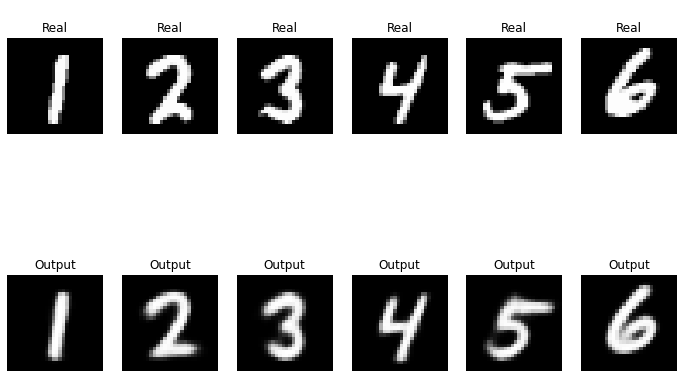

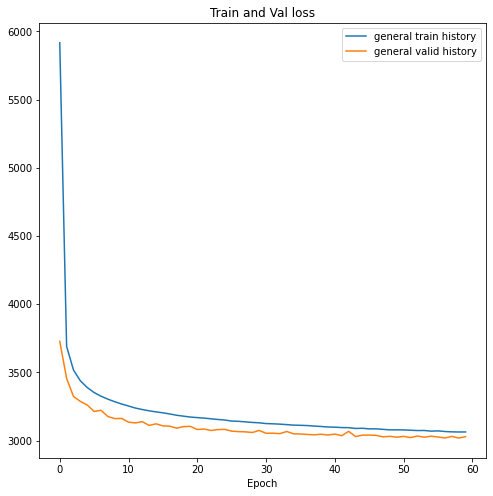

Epoch: 60
Train Loss: 3063.279
 Val. Loss: 3028.660


In [ ]:
train_losses_cvae, val_losses_cvae = train_cvae(model, optimizer=optimizer)

In [ ]:
torch.save(model.state_dict(), 'best-val-CVAE-model.pt')

In [ ]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
      reconstruction, mu, logsigma = model(batch[0].to(device), batch[1].to(device))
      reconstruction = reconstruction.view(-1, 1, 28, 28)
      result = reconstruction
      ground_truth = batch[0].numpy()
      break

In [ ]:
ground_truth.shape, result[0].shape

((32, 1, 28, 28), torch.Size([1, 28, 28]))

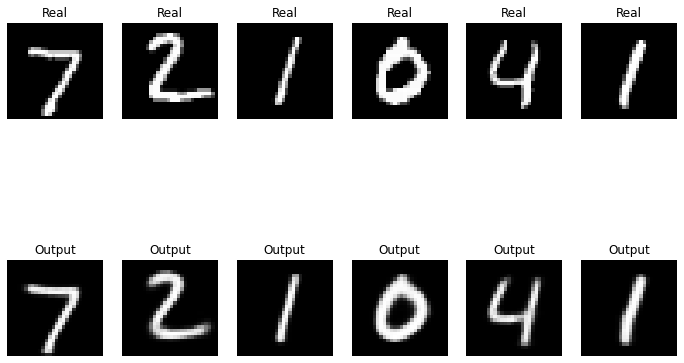

In [ ]:
fig, ax = plt.subplots(2, 6, figsize = (12, 8))
for k in range(6):
    ax[0, k].imshow(ground_truth[k].squeeze(), cmap='gray')
    ax[0, k].set_title("Real")
    ax[0, k].axis('off')
    ax[1, k].imshow(torch.squeeze(result[k]).cpu(), cmap='gray') #torch.squeeze(reconstructed.reshape(-1, 28, 28).cpu())
    ax[1, k].set_title("Output")
    ax[1, k].axis('off')  

## 3.2 Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
z = torch.randn(1, 8)
print(z.shape)
z = torch.cat([z,z])
z.shape

torch.Size([1, 8])


torch.Size([2, 8])

In [ ]:
# зададим цифры 5 и 7 для последующего восстановления
decimal = torch.tensor([5, 7])
decimal.shape

F.one_hot(decimal, num_classes = 10).shape

torch.Size([2, 10])

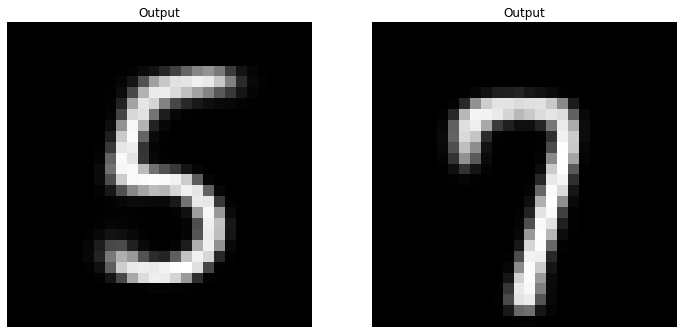

In [ ]:

model.eval()
with torch.no_grad():
    output = model.decode(z.to(device), decimal.to(device))
    out = torch.squeeze(output).cpu().detach().numpy()

fig, ax = plt.subplots(1, 2, figsize = (12, 8))
for k in range(2):    
    ax[k].imshow(out[k], cmap='gray')
    ax[k].set_title("Output")
    ax[k].axis('off')  

plt.show()


Splendid! Вы великолепны!


## 3.3 Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
model.eval()
latents = torch.FloatTensor()
with torch.no_grad():
    for batch in test_loader:      
      latent = model.get_latent_vector(batch[0].to(device), batch[1].to(device))
      latents = torch.cat((latents, latent.cpu()))    
labels = [i[1] for i in test_dataset]      

In [ ]:
import warnings
warnings.filterwarnings("ignore")

X_embedded = TSNE(n_components=2).fit_transform(latents)
X_embedded.shape

(10000, 2)

In [ ]:
# Создание диаграммы разброса
fig = px.scatter(None, x=X_embedded[:,0], y=X_embedded[:,1], 
                 labels={
                     "x": "Dimension 1",
                     "y": "Dimension 2"
                 }, opacity=1, color=labels)

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE")

# Обновление размера маркера
fig.update_traces(marker=dict(size=3))

fig.show()

Данное распределение точек в латентном пространстве для CVAE значительно отличается от распределения для VAE. Точки определяются, но при этом, здесь нет четких границ кластеров. 